In [262]:
import joblib
import numpy as np
import pandas as pd
import sklearn.preprocessing

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor


from matplotlib import pyplot as plt
import seaborn as sns
import joblib



In [263]:
def calculate_rmse(y_true:np.ndarray,y_pred:np.ndarray):
    '''
    Calculating the Root Mean Squared Error score
    :param y_true: true label values (not normalized)
    :param y_pred: prediction values (not normalized)
    :return: a list containing all RMSE score of each output column
    '''
    score_list=[]
    for i in range(y_true.shape[1]):
        score_list.append(np.sqrt(mean_squared_error(y_true[:,i],y_pred[:,i])))
    return score_list

In [265]:
data=pd.read_excel('data/dataBiomass_CE880.xlsx',skiprows=2,header=0).drop('Number',axis=1)
x=data.iloc[:,:8]
y=data.iloc[:,8:]


mms_x=MinMaxScaler()
mms_y=MinMaxScaler()
x_norm=mms_x.fit_transform(x)
y_norm=mms_y.fit_transform(y)

x_train,x_test,y_train,y_test=train_test_split(x_norm,y_norm,test_size=0.2)
y_test_denorm=mms_y.inverse_transform(y_test)

In [266]:
dtr=DecisionTreeRegressor()
param_grid_dtr={
    'max_depth':[5,10,20,None],
    'min_samples_split':[2,5,10]
}
gs_dtr=GridSearchCV(dtr,param_grid_dtr,scoring='neg_mean_squared_error')
gs_dtr.fit(x_train,y_train)
gs_dtr.best_score_

-0.011452333626079104

In [267]:
rfr=RandomForestRegressor()
param_grid_rfr={
    'n_estimators':[5,10,20,100],
    'max_depth':[5,10,20],
    'min_samples_split':[2,5,10]
}
gs_rfr=GridSearchCV(rfr,param_grid=param_grid_rfr,scoring='neg_mean_squared_error')
gs_rfr.fit(x_train,y_train)
gs_rfr.best_score_

-0.00960121665844266

In [268]:
# svr=MultiOutputRegressor(SVR())
# param_grid_svr = {
#     'estimator__kernel': ['linear', 'rbf'],
#     'estimator__C': [0.1, 1.0, 10.0],
#     'estimator__epsilon': [0.1, 0.2, 0.5],
# }
# grid_svr=GridSearchCV(svr,param_grid=param_grid_svr,scoring='neg_mean_squared_error')
# grid_svr.fit(x_train,y_train)
# grid_svr.best_score_

In [269]:
# svr.get_params().keys()

In [270]:
best_rfr=gs_rfr.best_estimator_
y_pred=best_rfr.predict(x_test)

In [271]:
y_pred_denorm=mms_y.inverse_transform(y_pred)
rfr_rmse_score=calculate_rmse(y_test_denorm,y_pred_denorm)


In [272]:
rfr_rmse_score

[4.718977323184871,
 3.771238013977855,
 4.53872573913984,
 1.6880821701046118,
 2.070365927599256,
 6.160866433714666,
 8.299520269425857]

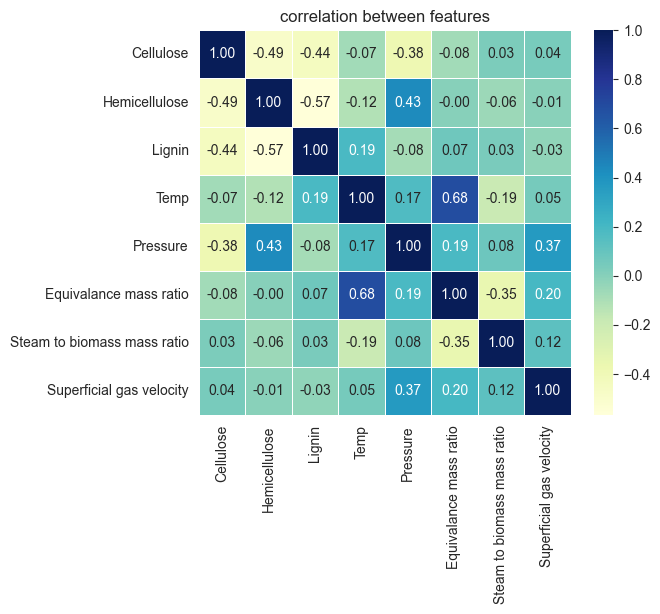

In [253]:
corr_matrix_feature=data.iloc[:,:8].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix_feature,cmap='YlGnBu',annot=True,linewidths=0.5,fmt='.2f')
plt.title('correlation between features')
plt.show()

In [254]:
# pca=PCA(n_components=4)
# x=pca.fit_transform(data.iloc[:,:8])
# y=data.iloc[:,8:]
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)


In [255]:
# dtr = DecisionTreeRegressor()
# param_grid_dtr = {
#     'max_depth': [5, 10, 20, None],
#     'min_samples_split': [2, 5, 10]
# }
# gs_dtr = GridSearchCV(dtr, param_grid_dtr, scoring='neg_mean_squared_error')
# gs_dtr.fit(x_train, y_train)
# gs_dtr.best_score_

In [256]:
# rfr = RandomForestRegressor()
# param_grid_rfr = {
#     'n_estimators': [5, 10, 20, 100],
#     'max_depth': [5, 10, 20],
#     'min_samples_split': [2, 5, 10]
# }
# gs_rfr = GridSearchCV(rfr, param_grid=param_grid_rfr, scoring='neg_mean_squared_error')
# gs_rfr.fit(x_train, y_train)
# gs_rfr.best_score_

In [257]:
# best_rfr = gs_rfr.best_estimator_
# y_pred = best_rfr.predict(x_test)
# y_pred
# score_list = []
# arr_y_test = np.array(y_test)
# for i in range(y_test.shape[1]):
#     score_list.append(np.sqrt(mean_squared_error(arr_y_test[:, i], y_pred[:, i])))
# score_list


In [258]:
# pca.explained_variance_ratio_

In [259]:
import NeuralNetwork
from importlib import reload
reload(NeuralNetwork)
from NeuralNetwork import MLPBiomass,BiomassDataset


import torch
from torch.utils.data import DataLoader

from torch.nn import MSELoss
from torch.optim import Adam

In [273]:
data_train=np.concatenate([x_train,y_train],axis=1)
data_test=np.concatenate([x_test,y_test],axis=1)
tensor_data_train=torch.tensor(data_train,dtype=torch.float32)
tensor_data_test=torch.tensor(data_test,dtype=torch.float32)
nn_model=MLPBiomass(8,7)
dataset=BiomassDataset(tensor_data_train)

n_epochs=5555

batch_size=32
dataloader=DataLoader(dataset,batch_size=batch_size,shuffle=True,drop_last=False)

criterion=MSELoss()
optimizer=Adam(nn_model.parameters(),lr=0.0002)

for epoch in range(n_epochs):
    # training    
    nn_model.train()
    for batch,batch_data in enumerate(dataloader):
        optimizer.zero_grad()
        feat,label=batch_data[:,:8],batch_data[:,8:]
        pred=nn_model(feat)
        loss=criterion(pred,label)
        
        loss.backward()
        optimizer.step()
    
    # validation
    tensor_x_test=tensor_data_test[:,:8]
    tensor_y_test=tensor_data_test[:,8:]
    
    pred_test=nn_model.forward(tensor_x_test)
    pred_test_denorm=mms_y.inverse_transform(pred_test.detach().numpy())
    score_list=calculate_rmse(y_test_denorm,pred_test_denorm)
    
    if epoch%20==0:
        print(f'epoch:{epoch} - {score_list}')

epoch:0 - [24.511164346894475, 22.943096487230314, 24.375595263688894, 7.751396506457813, 7.339219828060813, 16.18665098332198, 27.92633805540958]
epoch:20 - [10.788357152153697, 9.73057083960417, 8.545061846112116, 3.373641022539129, 3.2298854848624114, 10.304594126793457, 17.680639827961265]
epoch:40 - [10.169269237311, 6.311634524868639, 8.336810619354589, 2.2608757780439004, 2.6547576520817584, 9.44204742677649, 17.393086868540774]
epoch:60 - [9.917335241757891, 5.8749655765406885, 8.314936996545647, 2.2823504753436286, 2.3491054198664956, 8.798544893628428, 16.526197925903727]
epoch:80 - [9.77321124624733, 5.5146378645831255, 8.27071370768623, 2.3267222486881893, 2.3079289751476866, 8.700126211949458, 16.073827292848506]
epoch:100 - [9.65285077685171, 5.348177716709408, 8.239840617101116, 2.320494727491917, 2.2805461316385234, 8.537841321690737, 15.724929999339667]
epoch:120 - [9.542752947971527, 5.200895408930316, 8.165835154891159, 2.274546723239366, 2.270121677581392, 8.3843904

In [ ]:
rfr_rmse_score